## RTF: Switching Modes

This notebook is a tutorial on how you can switch from training the model with the convolutional form, to doing inference with the recurrent mode.

When training with `RTF` with `constraint=no`, the poles (roots of denominator) of the SSM may end up where numerical errors stack up when correcting the numerator via $C = \tilde{C}(I-A^\ell)^{-1}$ (for transfer function truncation) as shown below.

Flash FFT Conv imported? False


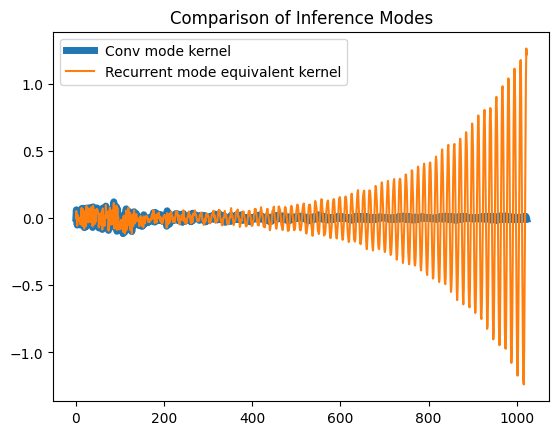

In [1]:
from rtf import RTF, RTF2
import torch
import matplotlib.pyplot as plt
torch.manual_seed(256)

seq_len = 1024
d_model = 1
init = "xavier" # Other options: "zeros" (default), "montel"
constraint = "no" # Other options: "no"|None (default)
batch_size = 1
input = torch.rand(batch_size, seq_len, d_model)

model = RTF(
	d_model=d_model, 
	state_size=128, 
	trunc_len=seq_len, 
	init=init, 
	constraint=constraint)

output = model(input)

k = model.get_k()
k_step = model.get_k_step(correct_C=True)

plt.title("Comparison of Inference Modes")
plt.plot(k.detach().cpu().T, linewidth=5, label="Conv mode kernel")
plt.plot(k_step.detach().cpu().T, label="Recurrent mode equivalent kernel")
plt.legend();

This can be resolved in several ways.

### Method 1. Post training distillation

Simply train the numerators to output a recurrence that matches the convolutional mode kernel using gradient descent. 

**Pros**:
- Simple and general
- Training is faster and more stable, due to not requiring numerator correction $\tilde{C} = C(I-A^\ell)$.
- Recurrent mode no longer requires numerator correction after distillation (but conv mode will be off)

**Cons**:
- Distillation process itself can be time-consuming if distilling multiple long kernels.
- Distillation process can be noisy.

In [2]:
from tqdm import tqdm
optim = torch.optim.Adam(model.parameters(), lr=0.001)
iters = 1000

k = model.get_k().detach()
for i in tqdm(range(iters)):
    optim.zero_grad()
    loss = torch.mean((k - model.get_k_step(correct_C=False))**2)
    loss.backward()
    optim.step()

100%|██████████████████████████████████████████████████████| 1000/1000 [03:07<00:00,  5.34it/s]


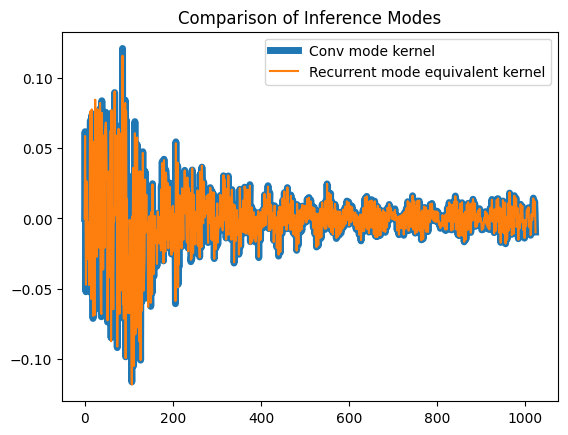

In [3]:
k_step = model.get_k_step(correct_C=False)

plt.title("Comparison of Inference Modes")
plt.plot(k.detach().cpu().T, linewidth=5, label="Conv mode kernel")
plt.plot(k_step.detach().cpu().T, label="Recurrent mode equivalent kernel")
plt.legend();

### Method 2. Pole constraining

Apply pole constraints such as `l1_montel`.

**Pros**:
- Makes training even more stable as now the system could only realize stable systems.
- Numerator correction `get_C` will always work and have minimal numerical errors.

**Cons**:
- The system is not as expressive, therefore performance could take a hit (see paper).

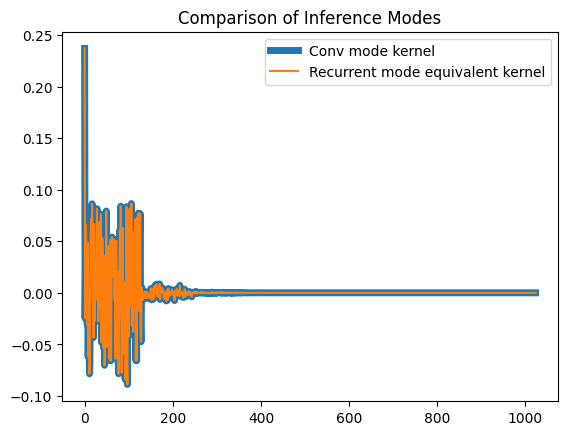

In [4]:
seq_len = 1024
d_model = 1
init = "xavier" # Other options: "zeros" (default), "montel"
constraint = "l1_montel"
batch_size = 1
input = torch.rand(batch_size, seq_len, d_model)

model = RTF(
	d_model=d_model, 
	state_size=128, 
	trunc_len=seq_len, 
	init=init, 
	constraint=constraint)

output = model(input)

k = model.get_k()
k_step = model.get_k_step(correct_C=True)

plt.title("Comparison of Inference Modes")
plt.plot(k.detach().cpu().T, linewidth=5, label="Conv mode kernel")
plt.plot(k_step.detach().cpu().T, label="Recurrent mode equivalent kernel")
plt.legend();

### Method 3. Conv mode numerator correction

Instead of applying numerator correction for recurrent inference `step()`, directly apply it during training when computing the convolutional kernel.
This is implemented in `RTF2` as shown below.

**Pros**:
- Conv mode correction is numerically more accurate as it no longer requires matrix inverse. However, training may be less stable as it can now realize unstable systems.
- Recurrent mode no longer requires numerator correction.

**Cons**:
- Numerator correction must be applied on every single training iteration, slowing the training algorithm down (and loses state-free property).

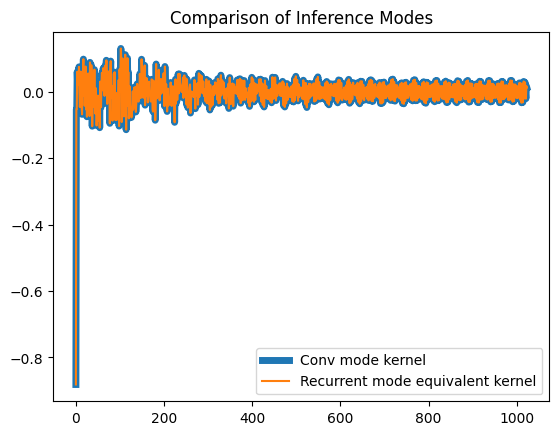

In [5]:
seq_len = 1024
d_model = 1
init = "xavier" # Other options: "zeros" (default), "montel"
constraint = "no"
batch_size = 1
input = torch.rand(batch_size, seq_len, d_model)

model = RTF2(
	d_model=d_model, 
	state_size=128, 
	trunc_len=seq_len, 
	init=init, 
	constraint=constraint)

output = model(input)

k = model.get_k()
k_step = model.get_k_step()

plt.title("Comparison of Inference Modes")
plt.plot(k.detach().cpu().T, linewidth=5, label="Conv mode kernel")
plt.plot(k_step.detach().cpu().T, label="Recurrent mode equivalent kernel")
plt.legend();

It is recommended to use Method 1 whenever possible, but in cases such as Reinforcement Learning where you may be required to switch between conv mode and recurrent mode quite often, consider using Method 2 or 3.